In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import math

#Import DecisionTree as a classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
from sklearn.metrics import precision_score

In [21]:
path = '/home/malpizar/Documents/MultipleScattering/backup/'
file = 'RecoilsData.csv'

df = pd.read_csv(path + file)

#drop events with no recoils at all
df = df[df['ar40recoils'] != 0]

#drop rows with the value -99999, these are outliers
df = df.drop(index=df[df.eq(-99999).any(axis=1)].index)

df.head()
print(df.shape)

(1209, 25)


In [22]:
#drop the variable used to make the flags for multiple recoils
df = df.drop(['ar40recoils'], axis=1) 
print(df.shape)

(1209, 24)


In [23]:
# Count the occurrences of each value in multiplerecoils
value_counts = df['multiplerecoils'].value_counts()
print(value_counts)
# Drop rows with multiplerecoils to make it more even between multiple and single
#df = df.drop(df[df['multiplerecoils'] == 1].head(659).index) #50-50
#df = df.drop(df[df['multiplerecoils'] == 1].head(659).index)
# Count the occurrences of each value in multiplerecoils again
value_counts = df['multiplerecoils'].value_counts()
print(value_counts)

1    934
0    275
Name: multiplerecoils, dtype: int64
1    934
0    275
Name: multiplerecoils, dtype: int64


In [24]:
# Get a random permutation of the DataFrame's index
random_order = np.random.RandomState(seed=9).permutation(df.index)

# Reorder the DataFrame randomly using the random permutation
df = df.loc[random_order]

In [25]:
# Count the occurrences of each value in multiplerecoils again
value_counts = df['multiplerecoils'].value_counts()
print(value_counts)

1    934
0    275
Name: multiplerecoils, dtype: int64


In [26]:
#dependent variable that will be predicted
var = 'multiplerecoils'

X = df.drop([var], axis=1)

# Select the dependent variable
y = df[var] 

print(X.shape)
print(y.shape)

(1209, 23)
(1209,)


In [27]:
# Create the GradientBoostingClassifier (Boosted Decision Tree)
boosted_tree = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

print("Created Boosted Decision Tree Classifier")

Created Boosted Decision Tree Classifier


In [28]:
# Perform cross-validation with 10 folds
# 'cv' parameter specifies the number of folds
# 'scoring' parameter specifies the evaluation metric (e.g., 'accuracy')
cross_val_scores = cross_val_score(boosted_tree, X, y, cv=10, scoring='accuracy')

# Print the cross-validation scores for each fold
print("Cross-Validation Scores:")
for fold, score in enumerate(cross_val_scores, start=1):
    print(f"Fold {fold}: {score:.2f}")

# Calculate and print the average cross-validation score
average_score = cross_val_scores.mean()
print(f"\nAverage Score: {average_score:.2f}")

Cross-Validation Scores:
Fold 1: 0.80
Fold 2: 0.76
Fold 3: 0.76
Fold 4: 0.82
Fold 5: 0.79
Fold 6: 0.81
Fold 7: 0.76
Fold 8: 0.82
Fold 9: 0.82
Fold 10: 0.74

Average Score: 0.79


In [11]:
#optional
#additional cross validation scores

scores = cross_validate(boosted_tree, X, y, cv=10, scoring='accuracy',return_train_score=True)

# Print the cross-validation scores for each fold
print("Cross-Validate Test Scores:")
for fold, score in enumerate(scores['test_score'], start=1):
    print(f"Fold {fold}: {score:.2f}")

# Calculate and print the average cross-validation score
average_scoreval = scores['test_score'].mean()
print(f"\nAverage Test Score: {average_scoreval:.2f}")

# Print the cross-validation train scores for each fold
print("\nCross-Validate Train Scores:")
for fold, score in enumerate(scores['train_score'], start=1):
    print(f"Fold {fold}: {score:.2f}")

# Calculate and print the average cross-validation score
average_scoreval = scores['train_score'].mean()
print(f"\nAverage Train Score: {average_scoreval:.2f}")

# Print the cross-validation fit times for each fold
print("\nFit Times (s):")
for fold, fit_time in enumerate(scores['fit_time'], start=1):
    print(f"Fold {fold}: {fit_time:.2f}")

# Calculate and print the average fit time
average_fittime = scores['fit_time'].mean()
print(f"\nAverage fit time: {average_fittime:.2f}")

# Print the cross-validation score times for each fold
print("\nScore Times (s):")
for fold, score_time in enumerate(scores['score_time'], start=1):
    print(f"Fold {fold}: {score_time:.2f}")

# Calculate and print the average score time
average_scoretime = scores['score_time'].mean()
print(f"\nAverage score time: {average_scoretime:.2f}")

Cross-Validate Test Scores:
Fold 1: 0.80
Fold 2: 0.76
Fold 3: 0.76
Fold 4: 0.82
Fold 5: 0.79
Fold 6: 0.81
Fold 7: 0.76
Fold 8: 0.82
Fold 9: 0.82
Fold 10: 0.74

Average Test Score: 0.79

Cross-Validate Train Scores:
Fold 1: 0.93
Fold 2: 0.92
Fold 3: 0.93
Fold 4: 0.94
Fold 5: 0.92
Fold 6: 0.93
Fold 7: 0.93
Fold 8: 0.94
Fold 9: 0.93
Fold 10: 0.93

Average Train Score: 0.93

Fit Times (s):
Fold 1: 0.46
Fold 2: 0.37
Fold 3: 0.49
Fold 4: 0.45
Fold 5: 0.40
Fold 6: 0.38
Fold 7: 0.37
Fold 8: 0.38
Fold 9: 0.37
Fold 10: 0.40

Average fit time: 0.41

Score Times (s):
Fold 1: 0.00
Fold 2: 0.00
Fold 3: 0.00
Fold 4: 0.00
Fold 5: 0.00
Fold 6: 0.00
Fold 7: 0.00
Fold 8: 0.00
Fold 9: 0.00
Fold 10: 0.00

Average score time: 0.00


In [29]:
# Splitting the dataset to Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(967, 23)
(967,)
(242, 23)
(242,)


In [30]:
#Train DT
boosted_tree.fit(X_train, y_train)
print("Training set score: %f" % boosted_tree.score(X_train, y_train))
print("Test set score: %f" % boosted_tree.score(X_test, y_test))

Training set score: 0.927611
Test set score: 0.814050


In [31]:
# Make predictions on the test set
y_pred = boosted_tree.predict(X_test)

In [32]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.81405


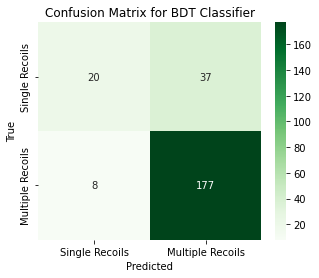

In [39]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
# Create a mapping dictionary to replace 0 with 'single' and 1 with 'multiple'
#label_mapping = {0: 'single recoils', 1: 'multiple recoils'}

# Replace the labels using the mapping dictionary
#df[var] = df[var].replace(label_mapping)

#class_labels = df[var].unique()
#class_labels = ['single recoils', 'multiple recoils'] #negative, positive

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

# Add a legend
tick_marks = np.arange(len(df[var].unique())) + 0.5
plt.xticks(tick_marks, ['Single Recoils', 'Multiple Recoils'])
plt.yticks(tick_marks, ['Single Recoils', 'Multiple Recoils'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for BDT Classifier')

# Display the plot
plt.show()

In [34]:
#calculate recall, precision and F1 score

rec = recall_score(y_test, y_pred)#, average='binary')
#The recall is intuitively the ability of the classifier to find all the positive samples.
pres = precision_score(y_test, y_pred)#, average='binary')
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
F1_score = 2/((1/rec) + (1/pres))
#F1 is the harmmonic mean between recall and precision

#weighted metrics
wrec = recall_score(y_test, y_pred, average='weighted')
wpres = precision_score(y_test, y_pred, average='weighted')
wF1_score = 2/((1/wrec) + (1/wpres))

print("The recall is: ", rec)
print("The precision is: ", pres)
print("The F1-score is: ", F1_score)

print("\nThe weighted recall is: ", wrec)
print("The weighted precision is: ", wpres)
print("The weighted F1-score is: ", wF1_score)

The recall is:  0.9567567567567568
The precision is:  0.8271028037383178
The F1-score is:  0.8872180451127819

The weighted recall is:  0.8140495867768595
The weighted precision is:  0.8005301834953493
The weighted F1-score is:  0.8072332839484601


In [35]:
#metrics by hand

tn, fp, fn, tp = cm.ravel()

err = (fp + fn)/(fp + fn + tn + tp)
acc = (tp + tn)/(fp + fn + tn + tp)
re = tp/(tp + fn)
sp = tn/(tn + fp)
prec = tp/(tp + fp)
fpr = fp/(tn + fp)
mcc = ((tp*tn) - (fp*fn))/math.sqrt((tp + fp)*(tp + tn)*(tn + fp)*(tn + fn))
F1 = 2/((1/re) + (1/prec))

print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)
print("True Positive:", tp)
print("\nError rate:", err)
print("Accuracy:", acc)
print("Recall:", re) #sensitivity, true positive rate
print("Specificity:", sp) #true negative rate
print("Precision:", prec) #positive predictive value
print("False positive rate:", fpr)
print("Mathews correlation coefficient:", mcc)
print("F1 score:", F1)




True Negative: 20
False Positive: 37
False Negative: 8
True Positive: 177

Error rate: 0.1859504132231405
Accuracy: 0.8140495867768595
Recall: 0.9567567567567568
Specificity: 0.3508771929824561
Precision: 0.8271028037383178
False positive rate: 0.6491228070175439
Mathews correlation coefficient: 0.3954798878038077
F1 score: 0.8872180451127819


In [36]:
# Get the feature importances
importance = boosted_tree.feature_importances_

# Create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Sum all the importance values
total_importance = feature_importances_df.sum()
print("")
print(f"Total Importance: {total_importance['Importance']}")

                   Feature  Importance
14          rprompt60Bayes    0.167773
1                  fprompt    0.147616
5                   fmaxpe    0.102000
7            chargetopring    0.069379
13                nSCBayes    0.064147
17           mblikelihoodZ    0.063141
18           mblikelihoodR    0.057841
3                eventTime    0.047502
0                      qPE    0.036011
16           mblikelihoodY    0.033645
10  chargesecondbottomring    0.029615
11   chargethirdbottomring    0.028005
12      pulseindexfirstgar    0.025253
20               timefit2Y    0.024059
8         chargesecondring    0.021808
22                  deltat    0.021399
15           mblikelihoodX    0.018589
9         chargebottomring    0.017443
19               timefit2X    0.012830
21               timefit2Z    0.007597
4           numEarlyPulses    0.004189
2                subeventN    0.000158
6                neckVetoN    0.000000

Total Importance: 0.9999999999999998


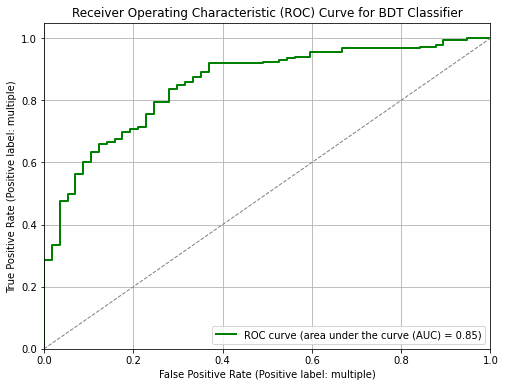

In [37]:
# Get predicted probabilities for the positive class (1) on the test set
y_prob = boosted_tree.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='g', lw=2, label='ROC curve (area under the curve (AUC) = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Positive label: multiple)')
plt.ylabel('True Positive Rate (Positive label: multiple)')
plt.title('Receiver Operating Characteristic (ROC) Curve for BDT Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()